In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
% matplotlib inline

In [3]:
df = pd.read_csv('Train_SU63ISt.csv')
df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [4]:
df.describe()

,ID,Count
count,18288.000000,18288.000000
mean,9143.500000,138.958115
std,5279.435197,153.467461
min,0.000000,2.000000
25%,4571.750000,22.000000
50%,9143.500000,84.000000
75%,13715.250000,210.000000
max,18287.000000,1244.000000


In [5]:
# important to plot correctly!
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M')
df.set_index("Datetime", inplace=True)

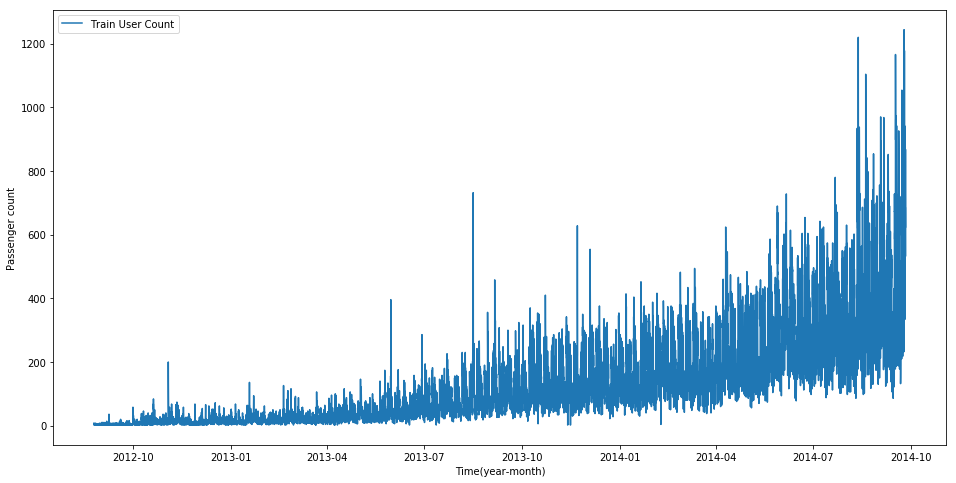

In [6]:
plt.figure(figsize=(16, 8))
plt.plot(df['Count'], label='Train User Count')
plt.xlabel("Time(year-month)")
plt.ylabel("Passenger count")
plt.legend(loc='best')

The graph shows an increase in trend over time. This is particularly so towards the end of 2014.

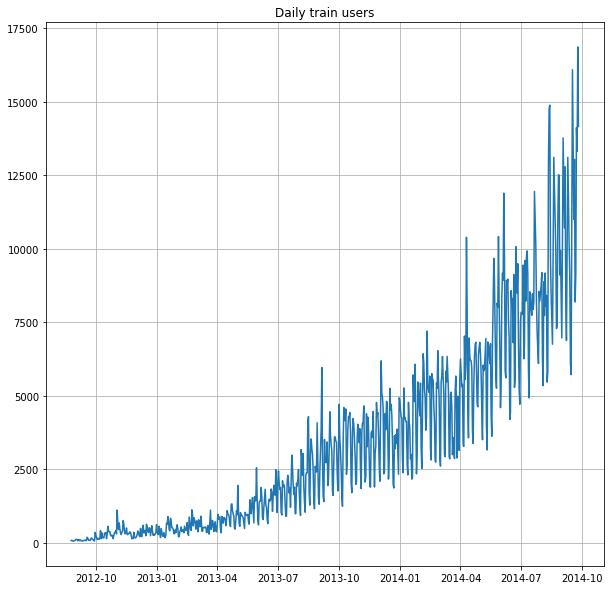

In [7]:
df.groupby([df.index.date])['Count'].sum().plot(figsize=(10,10), title='Daily train users', grid=True)

## Any missing data?

In [8]:
df.index.min(), df.index.max()

(Timestamp('2012-08-25 00:00:00'), Timestamp('2014-09-25 23:00:00'))

In [9]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

In [10]:
from collections import Counter
Counter(df['year'])

Counter({2012: 3096, 2013: 8760, 2014: 6432})

2012: Data starts from Aug 2012, meaning that there are 8 months worth of datapoints not available for analysis.

2013: Each full year should have at least 8760 datapoints. No missing datapoints for 2013.

2014: Data ends in Sept 2014, meaning that there are 3 months less datapoints.

# Feature Extraction and Exploratory Analysis & Hypothesis Validation

## Has train users been increasing over time?

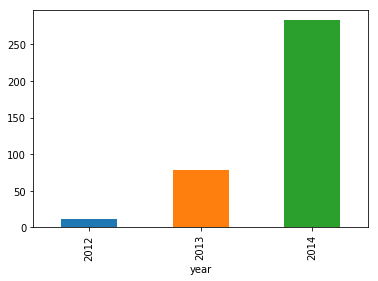

In [11]:
df.groupby(['year'])['Count'].mean().plot(kind='bar')

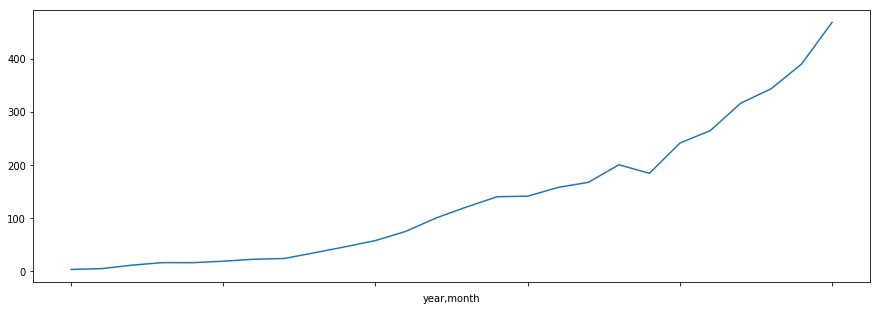

In [12]:
df.groupby(['year', 'month'])['Count'].mean().plot(figsize=(15,5))

Train users in Year 2014 had increased by 3 folds from Year 2013 inspite 3 months worth of data being missing from analysis.

Noting from the line graph above that the increase was a result from train users gradually increasing over time.

Although the last 3 months of Year 2014 is not available, based on the trend, it can be expected that the values would be higher than the numbers in 2013 for the same 3 months

## Holiday season trends?

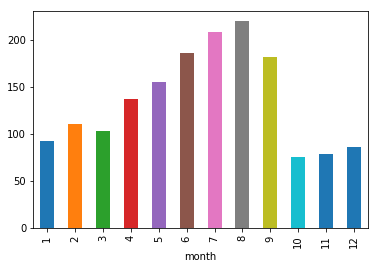

In [13]:
df.groupby(['month'])['Count'].mean().plot(kind='bar')

Jan to Aug 2012 and Oct to Dec 2014 is missing from data!

## Any trends based on dates?

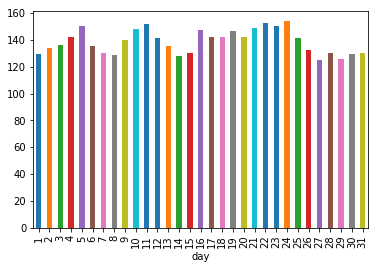

In [14]:
df.groupby(['day'])['Count'].mean().plot(kind='bar')

Nope, no noticeable trends based on days.

## peak vs non peak hours

In [15]:
df['hour'] = df.index.hour
PEAK_AM_START = 7
PEAK_AM_END = 10
PEAK_PM_START = 16
PEAK_PM_END = 19
df['peak'] = (((df['hour'] >= PEAK_AM_START) & (df['hour'] <= PEAK_AM_END)) | ((df['hour'] >= PEAK_PM_START) & (df['hour'] <= PEAK_PM_END)))

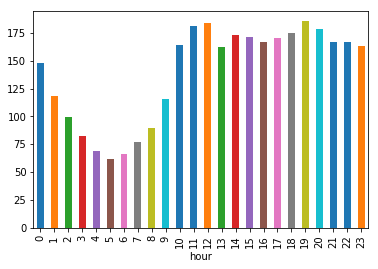

In [16]:
df.groupby(['hour'])['Count'].mean().plot(kind='bar')

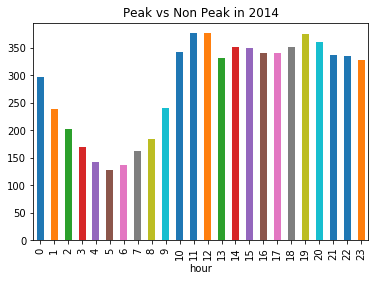

In [17]:
df[df.year==2014].groupby(['hour'])['Count'].mean().plot(kind='bar', title='Peak vs Non Peak in 2014')

The hours with highest traffic are at 11-12noon and 7 to 8pm. With 2nd hald of the day (up to midnight) attracting much higher traffic as compared to the 1st half. 

Traffic slows down from midnight to 5am; and it picks up from 5am up to 12noon

## weekend vs weekday

In [18]:
# 5&6 means weekend
df['dOW'] = df.index.dayofweek

In [19]:
df['weekend'] = df['dOW'].apply(lambda x: int(6<=x>=5))

In [20]:
df.drop("ID", 1, inplace=True)

In [21]:
df.head()

,Count,year,month,day,hour,peak,dOW,weekend
Datetime,,,,,,,,
2012-08-25 00:00:00,8,2012,8,25,0,False,5,0
2012-08-25 01:00:00,2,2012,8,25,1,False,5,0
2012-08-25 02:00:00,6,2012,8,25,2,False,5,0
2012-08-25 03:00:00,2,2012,8,25,3,False,5,0
2012-08-25 04:00:00,2,2012,8,25,4,False,5,0


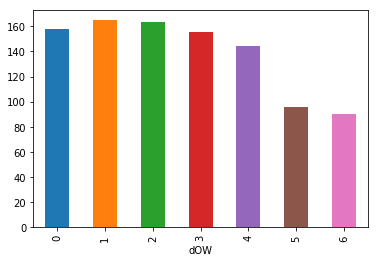

In [22]:
df.groupby(['dOW'])['Count'].mean().plot(kind='bar')

Value 5 & 6 represents weekends. From the graph above, it coincides with our assumptions that work days tend to have higher and consistent volumes of train users as compared to weekends.

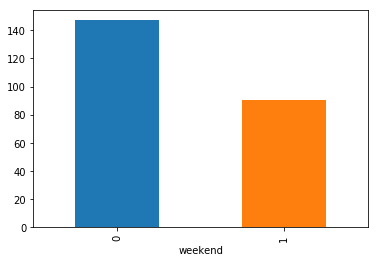

In [23]:
df.groupby(['weekend'])['Count'].mean().plot(kind='bar')

### Could it be caused by late night travels during weekends?

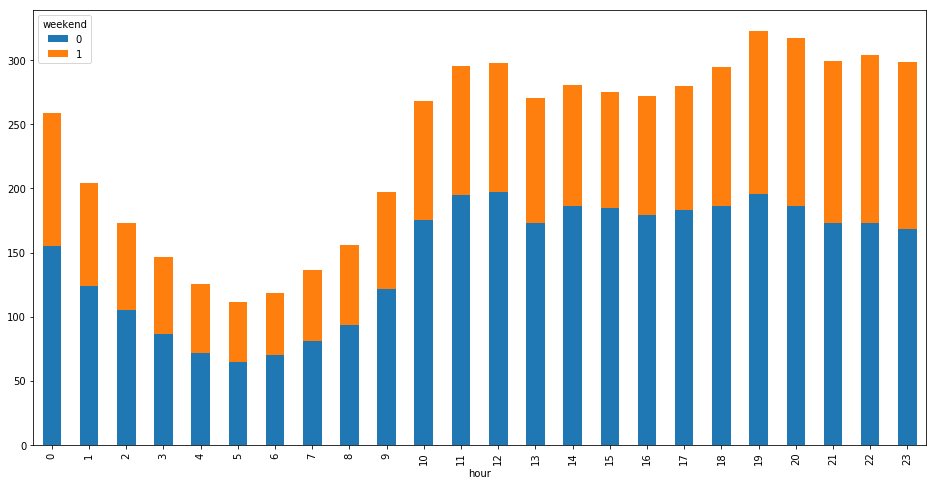

In [24]:
df.groupby(['weekend', 'hour'])['Count'].mean().unstack().T.plot(kind='bar', stacked=True, figsize=(16, 8))

This hypothesis is not valid. Overall, weekend train users are fewer as compared to weekdays regardless of the hour

# Aggregate data to reduce noise

In [25]:
# Hourly time series
hourly = df.resample('H').mean()

# Converting to daily mean
daily = df.resample('D').mean()

# Converting to weekly mean
weekly = df.resample('W').mean()

# Converting to monthly mean
monthly = df.resample('M').mean()

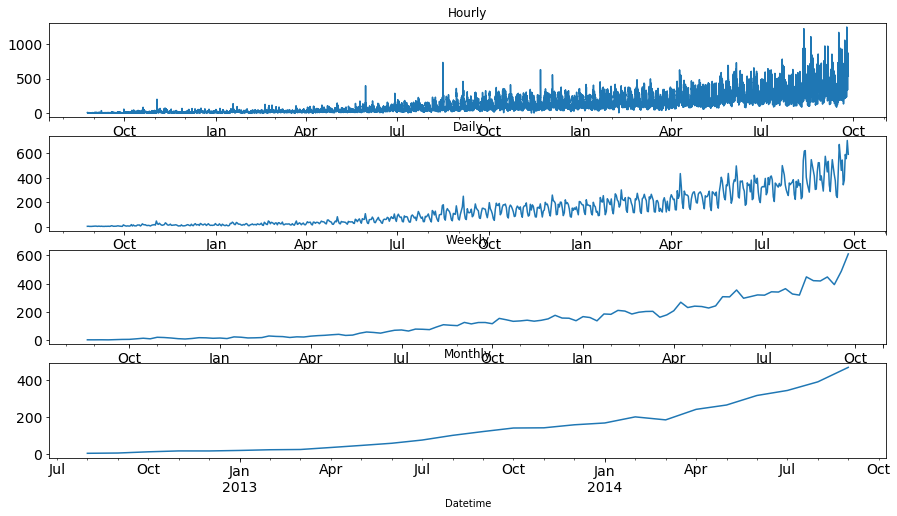

In [26]:
fig, axs = plt.subplots(4,1)

hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2])
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3])

plt.show()

Purpose of aggregating data - timeseries become more stable as they get aggregated into bigger groups.

# Split data into training and validation set

For timeseries, the last X months should be for validation set. The rest for training data.

We could choose to split at random but it would not work effectively for validation set. Taking some values from the starting and some from the last years will be similar to predicting the old values based on the future values which is not the case in real scenario

In [27]:
Train=daily.loc['2012-08-25':'2014-06-24']
valid=daily.loc['2014-06-25':'2014-09-25']

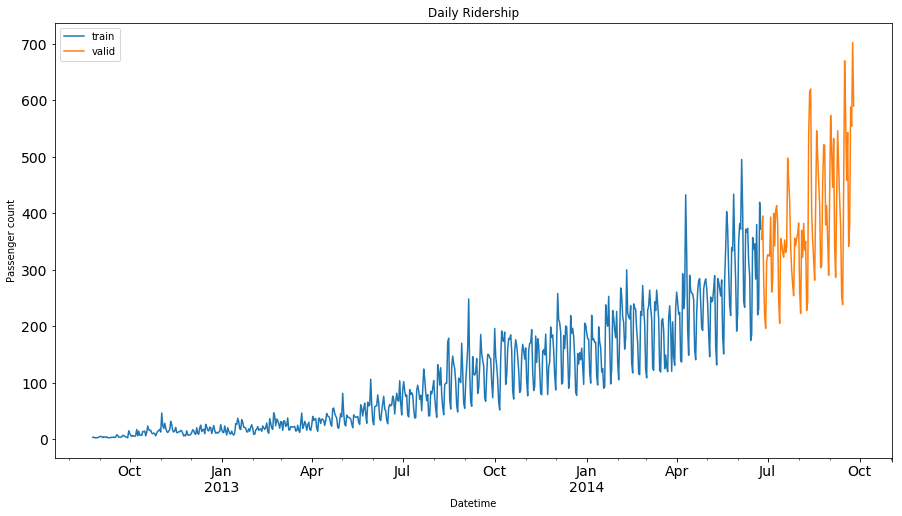

In [28]:
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train')
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid')
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

# Modeling techniques

### Visualise decomposed arts of timeseries

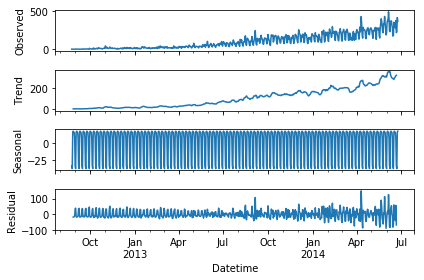

In [29]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(Train.Count).plot()
result = sm.tsa.stattools.adfuller(Train.Count)
plt.show()

## Naive Method

assumes that the next expected point is equal to the last observed point

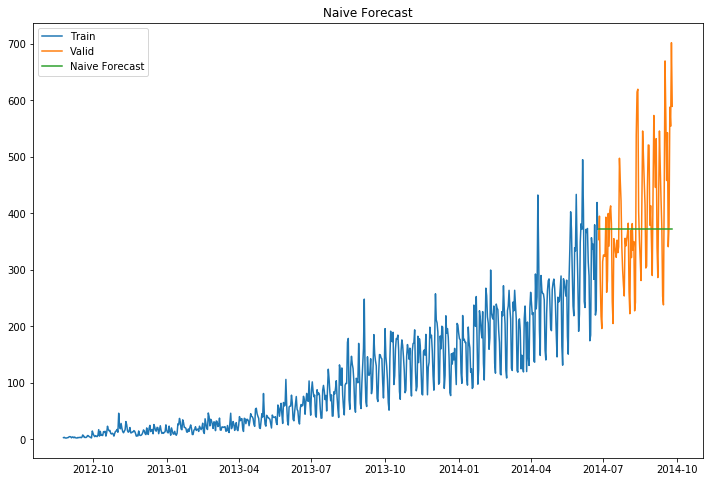

In [30]:
num_valpoints = valid['Count'].count()
df_rows = Train['Count'].count()

y_hat = valid.copy()
y_hat['naive'] = Train.iloc[df_rows-1]['Count']
plt.figure(figsize=(12,8))
plt.plot(Train.index, Train['Count'], label='Train')
plt.plot(valid.index,valid['Count'], label='Valid')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(valid.Count, y_hat.naive))
rms

111.79050467496724

rms value is high for Naive approach indicating that this method is not suitable for dataset with high variability

## Moving Average


take average counts for last few periods only. Why?

Moving average for last 10 days: 313.0333333333333
RMSE for last 10 days: 134.23733308950264


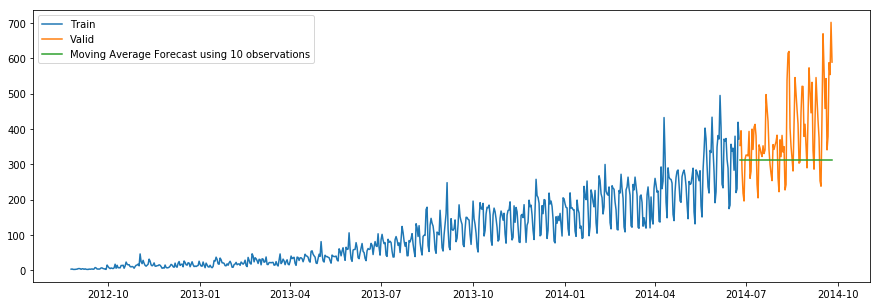

Moving average for last 20 days: 319.91666666666663
RMSE for last 20 days: 130.44984977550422


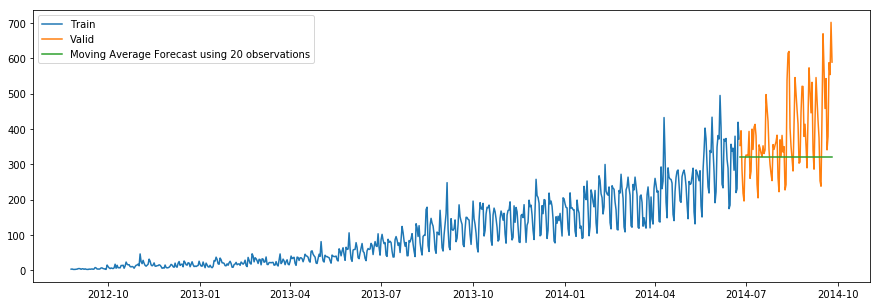

Moving average for last 50 days: 296.62666666666655
RMSE for last 50 days: 144.19175679986802


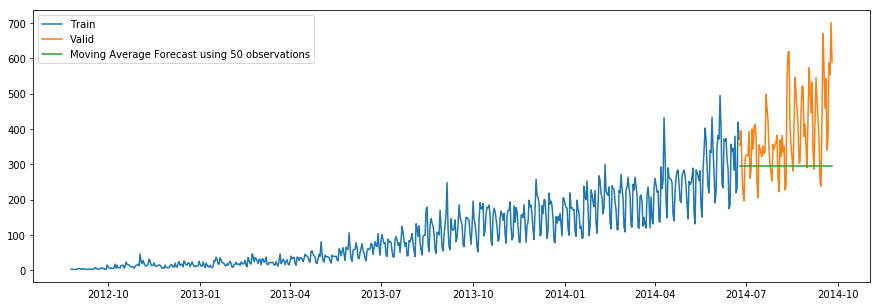

In [32]:
# last 10 days
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1] # average of last 10 observations.
print("Moving average for last 10 days: {}".format(y_hat_avg['moving_avg_forecast'][0]))
print("RMSE for last 10 days: {}".format(sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast))))
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations')
plt.legend(loc='best')
plt.show()

# last 20 days
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(20).mean().iloc[-1] # average of last 20 observations.
print("Moving average for last 20 days: {}".format(y_hat_avg['moving_avg_forecast'][0]))
print("RMSE for last 20 days: {}".format(sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast))))
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 20 observations')
plt.legend(loc='best')
plt.show()

# last 50 days
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(50).mean().iloc[-1] # average of last 50 observations.
print("Moving average for last 50 days: {}".format(y_hat_avg['moving_avg_forecast'][0]))
print("RMSE for last 50 days: {}".format(sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast))))
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 50 observations')
plt.legend(loc='best')
plt.show()

Predictions became weaker as the number of observations increased (the further back we look)

## Simple Exponential Smoothing

larger weights to more recent observations than to observations from the distant past.

If we give the entire weight to the last observed value only, this method will be similar to the naive approach

In [33]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

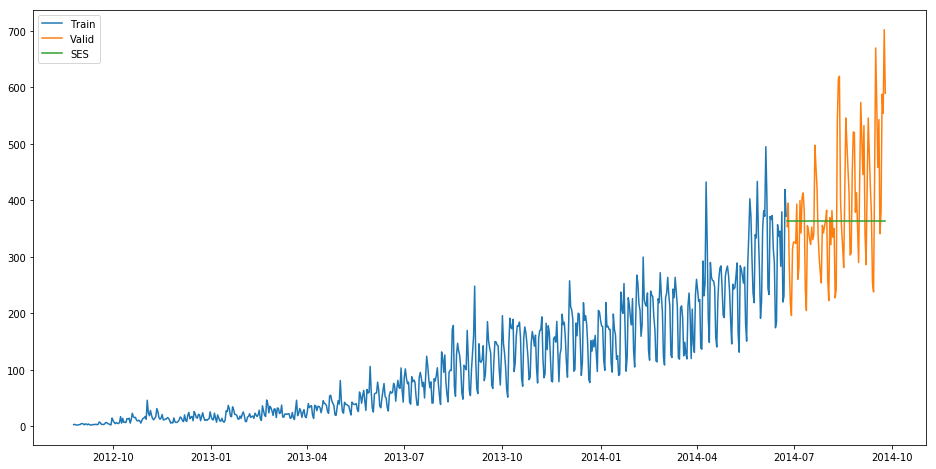

In [34]:
y_hat_avg = valid.copy()
ses = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = ses.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [35]:
sqrt(mean_squared_error(valid.Count, y_hat_avg.SES))

113.43708111884514

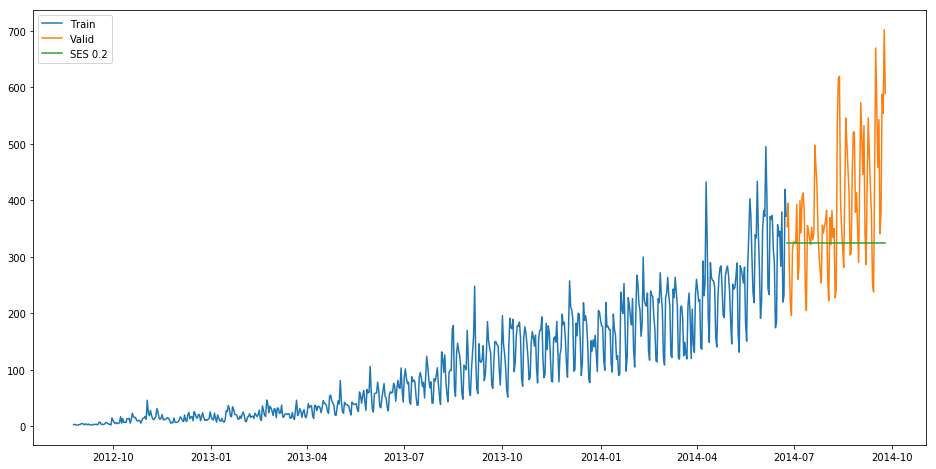

In [36]:
y_hat_avg = valid.copy()
ses2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.2,optimized=False)
y_hat_avg['SESp2'] = ses2.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['SESp2'], label='SES 0.2')
plt.legend(loc='best')
plt.show()

In [37]:
sqrt(mean_squared_error(valid.Count, y_hat_avg.SESp2))

128.05565831088646

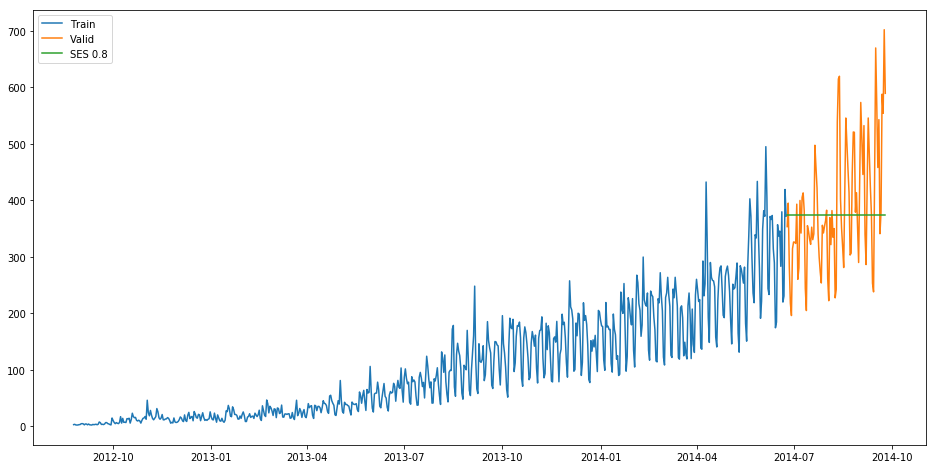

In [38]:
y_hat_avg = valid.copy()
ses8 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.8,optimized=False)
y_hat_avg['SESp8'] = ses8.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['SESp8'], label='SES 0.8')
plt.legend(loc='best')
plt.show()

In [39]:
sqrt(mean_squared_error(valid.Count, y_hat_avg.SESp8))

111.49488572738103

As smoothing level increase, the rmse improves (decreases). RMSE achieved by SES is better than Moving Average

## Holt's Linear Trend

extension of simple exponential smoothing to allow forecasting of data with a trend.

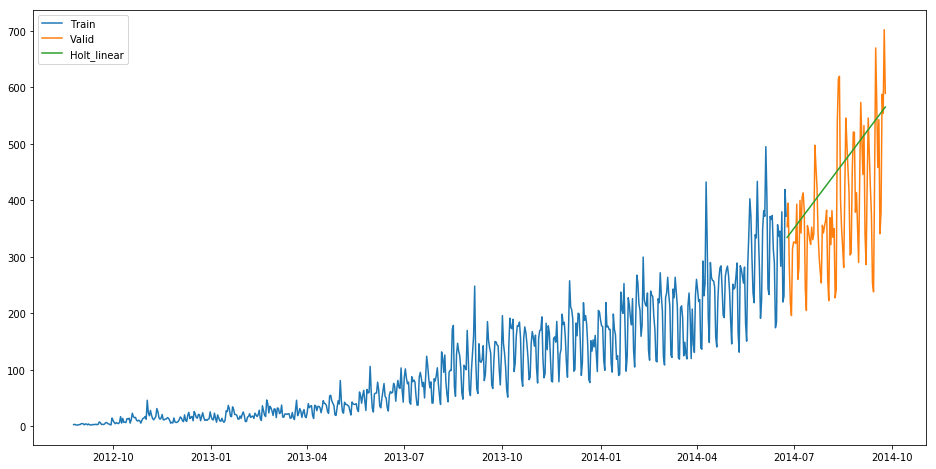

In [40]:
y_hat_avg = valid.copy()

fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level=0.3, smoothing_slope=0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid))

plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [41]:
sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_linear))

112.94278345314041

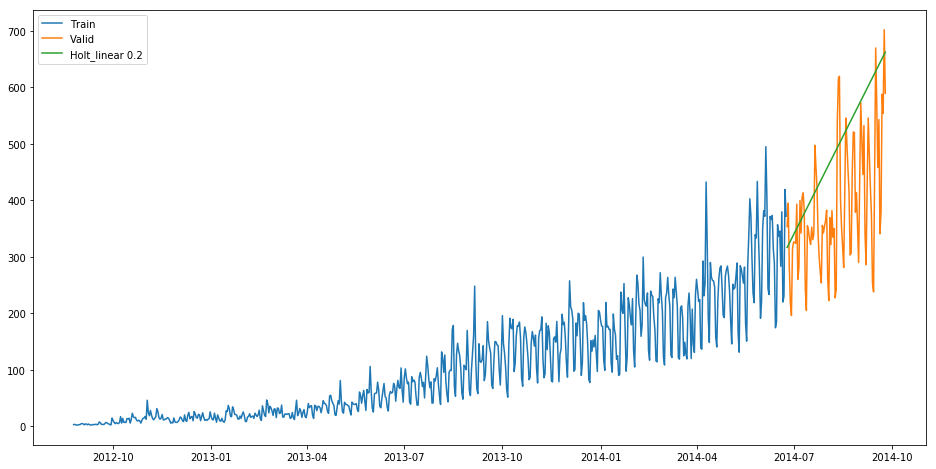

In [42]:
y_hat_avg = valid.copy()

fitp2 = Holt(np.asarray(Train['Count'])).fit(smoothing_level=0.2, smoothing_slope=0.2)
y_hat_avg['Holt_linearP2'] = fitp2.forecast(len(valid))

plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['Holt_linearP2'], label='Holt_linear 0.2')
plt.legend(loc='best')
plt.show()

In [43]:
sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_linearP2))

144.84461260091356

## RMSE
RMSE is the standard deviation of residuals

Residuals - how far from the regression line datapoint is

# Test Set

In [55]:
test_df = pd.read_csv('Test_0qrQsBZ.csv')
test_df['Datetime'] = pd.to_datetime(test_df['Datetime'], format='%d-%m-%Y %H:%M')
test_df.set_index("Datetime", inplace=True)
test_df.head()

,ID
Datetime,
2014-09-26 00:00:00,18288
2014-09-26 01:00:00,18289
2014-09-26 02:00:00,18290
2014-09-26 03:00:00,18291
2014-09-26 04:00:00,18292


In [45]:
test_df.index.min()

Timestamp('2014-01-10 00:00:00')

In [57]:
daily_test = test_df.resample('D').mean()

In [59]:
daily_prediction = fit1.forecast(daily_test.size)

In [60]:
# Calculating the hourly ratio of count
df['ratio']=df['Count']/df['Count'].sum()
df.head()
# Grouping the hourly ratio
temp=train_original.groupby(['Hour'])['ratio'].sum()

# Groupby to csv format
pd.DataFrame(temp, columns=['Hour','ratio']).to_csv('GROUPby.csv')

temp2=pd.read_csv("GROUPby.csv")
temp2=temp2.drop('Hour.1',1)

# Merge Test and test_original on day, month and year
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left')
merge['Hour']=merge['Hour_y']
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1)

# Predicting by merging merge and temp2
prediction=pd.merge(merge, temp2, on='Hour', how='left')

# Converting the ratio to the original scale
prediction['Count']=prediction['prediction']*prediction['ratio']*24
prediction['ID']=prediction['ID_y']

,Count,year,month,day,hour,peak,dOW,weekend,ratio
Datetime,,,,,,,,,
2012-08-25 00:00:00,8,2012,8,25,0,False,5,0,3.148037e-06
2012-08-25 01:00:00,2,2012,8,25,1,False,5,0,7.870093e-07
2012-08-25 02:00:00,6,2012,8,25,2,False,5,0,2.361028e-06
2012-08-25 03:00:00,2,2012,8,25,3,False,5,0,7.870093e-07
2012-08-25 04:00:00,2,2012,8,25,4,False,5,0,7.870093e-07


In [51]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

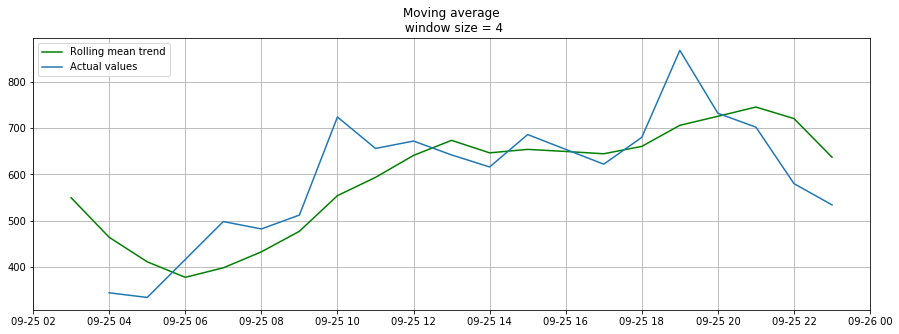

In [52]:
plotMovingAverage(df['Count'][-24:], 4)

## Reference
https://trainings.analyticsvidhya.com/courses/course-v1:AnalyticsVidhya+TS_101+TS_term1/courseware/a869013c2e274d1c82cd2fc50e64fb2d/e1ca0a12a88943c3a60c6d699b965a97/?activate_block_id=block-v1%3AAnalyticsVidhya%2BTS_101%2BTS_term1%2Btype%40sequential%2Bblock%40e1ca0a12a88943c3a60c6d699b965a97